In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#argument 'thousands=','' avoids that comma is kept in numeric values
dataset_train = pd.read_csv('Google_Price_Train_2012-2016.csv', thousands=',')

#select just the Close column
dataset_train_close = dataset_train['Close']

#change datatype of Close column from object to float
dataset_train_close = pd.to_numeric(dataset_train_close, errors='coerce')

#extract the 'Open' column
dataset_train_open = dataset_train['Open']


In [2]:
#transform series into arrays
dataset_train_open_array = dataset_train_open.values
dataset_train_close_array = dataset_train_close.values

#reshape to vertical structure and make 2D array
open = dataset_train_open_array.reshape(-1, 1)
close = dataset_train_close_array.reshape(-1, 1)

#concatenate the 2 arrays
training_set = np.concatenate((open, close), axis = 1)

training_set.shape

(1258, 2)

In [3]:
#feature scaling with normalisation
from sklearn.preprocessing import MinMaxScaler
#'sc' is an object of the MinMaxScaler class
#the scaled stock prices will be between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
#apply the scaler on the data
training_set_scaled = sc.fit_transform(training_set)

In [4]:
#create data structure with 60 timesteps and 1 output
#timesteps means: for one output in time t, it will check the values 
#of the 60 moments before
X_train = []
y_train = []
#60 is the starting point (we need the days before to create first training value)
#1258 is the index of the last day
for i in range(60, 1258):
    #get previous 60 values
    #'1' specifies the columns (we have two columns)
    X_train.append(training_set_scaled[i-60:i, 0:2])
    y_train.append(training_set_scaled[i, 0])
#make arrays from the lists
X_train, y_train = np.array(X_train), np.array(y_train)


In [5]:
#reshape data and add more dimensions
#define number of indicators
#currently we have two indicators ('open' and 'close' stock price)
#we for example can add stock prices of another company
#'X_train.shape[0]' is the number of lines
#'X_train.shape[1]' is the number of columns
#'2' is the number of indicators (here we take 2 indicators)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_train.shape

(1198, 60, 2)

In [ ]:
#import keras libraries & packages

#that helps us to set up a sequence of layers
from keras.models import Sequential
#'Dense' produces the output layer
from keras.layers import Dense
#getting the LSTM layers
from keras.layers import LSTM
#use dropout to avoid overfitting
from keras.layers import Dropout

from keras import optimizers

In [ ]:
#initialize the RNN
#'regressor' is used to predict a continuous value
#'regressor' is an object of the 'Sequential' class
regressor = Sequential()

#add first LSTM layer and dropout regularization
#LSTM object has 3 arguments:
#1) number of units (neurons; LSTM cells)
#2) return sequences: has to be true, cause we build a stacked LSTM
#3) input shape (relates to shape of X_train; 2 last dimensions are enough)
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 2)))

#add dropout regularization
#Dropout rate has one argument:
#--> dropout rate (number of neurons, that should be switched off 
#during each iteration of the training)
regressor.add(Dropout(0.2))

#2nd layer
#we don't need to specifiy input shape anymore
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#3nd layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#4th layer
#we remove 'return_sequences = True' and keep the default value --> 'false'
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#add output layer
regressor.add(Dense(units = 1))

#compile RNN with right optimizer
#and right loss function
#use 'compile' method of the 'sequential' class
#different optimizers can be found on keras documentation

regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error')

In [ ]:
#fit RNN to training set
#'batch_size' means: in every epoch, the model takes 32 observations
#and updates the weights accordingly
# 1258 total observations / 32 observations per batch =^ 38
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 11s 108ms/step - loss: 0.1002
Epoch 2/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0070
Epoch 3/100
38/38 [==============================] - 4s 110ms/step - loss: 0.0055
Epoch 4/100
38/38 [==============================] - 4s 113ms/step - loss: 0.0061
Epoch 5/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0050
Epoch 6/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0054
Epoch 7/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0044
Epoch 8/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0043
Epoch 10/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0046
Epoch 11/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0052
Epoch 12/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0037
Epoch 13/100

In [ ]:
#save the model
from keras.models import load_model
regressor.save('reg_google_ind2_open_close_2012-2016.h5')


In [6]:
#making predictions and visualize results

#get real stock price of January 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

#only consider 'Open' and 'Close' columns
dataset_test = dataset_test[['Open', 'Close']]
#real_stock_price = dataset_test.iloc[:, 1:3].values
real_stock_price = dataset_test.values

#'real_stock_price' contains 20 observations
real_stock_price.shape

(20, 2)

In [7]:
#get predicted stock price of 2017

#in order to predict stockprice of one day in Jan 17,
#we need 60 previous days
#for these 60 days, we need training and test set

#we will concatenate the initial dataframes
#then we will scale the values
#we have to scale the input values 
#cause the rnn was trained on the scaled values

#for vertical concatenation, we take: axis = 0
#for horizontal concatenation, we take: axis = 1
dataset_total = pd.concat((dataset_train[['Open', 'Close']], dataset_test[['Open', 'Close']]), axis = 0)

#get inputs of 60 previous days
#first financial day that we want to predict is Jan 3
#we get the index with this expression: [len(dataset_total) - len(dataset_test)]
#--> length of dataset_test is 20

#we get the lower bound with this expression: len(dataset_total) - len(dataset_test) - 60
#the upper bound is the last index of the whole dataset
#with 'values' we get a numpy array
#'inputs' gives us all information to predict values of Jan 2017
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

#reshape to get right numpy shape
#now we have the observations in lines and in 2 columns
inputs = inputs.reshape(-1, 2)

#scale the inputs (but not the test values)
#here we don't take the 'fit_transform' method, because 
#'sc' was already prepared
inputs = sc.transform(inputs)
inputs.shape


(80, 2)

In [8]:
#make 3d structure for test set

X_test = []
#upper bound is 80: 60 + 20 (we have 20 financial days in the test set)
for i in range(60, 80):
    #get previous 60 values for each of the stock prices in Jan 2017
    #'：' specifies the columns (we take all columns)
    X_test.append(inputs[i-60:i, :])
#make arrays from the lists
X_test = np.array(X_test)

#reshape data and add more dimensions
#define number of indicators
#currently we have one indicator ('open' stock price)
#we for example can add stock prices of another company
#'X_train.shape[0]' is the number of lines
#'X_train.shape[1]' is the number of columns
#'2' is the number of indicators (here we only take google stock price)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

## Get predictions based on training set from 2012 to 2016

In [9]:
from keras.models import load_model
regressor = load_model('reg_google_ind2_open_close_2012-2016.h5')

In [10]:
#make predictions on the values of X_test (Jan 2017)
predicted_stock_price = regressor.predict(X_test)

#make 2D structure of array
predicted_stock_price_2D = np.reshape(predicted_stock_price, (-1, 1))

#change training_set_scaled[:,1] to 2D array and only take last 20 values
#B = np.reshape(A, (-1, 2))
close_price_2D = np.reshape(training_set_scaled[:20,1], (-1, 1))

#add close_price_2D to array 'predicted_stock_price_2D'
predicted_stock_close_price_2D = np.concatenate((predicted_stock_price_2D, close_price_2D), axis = 1)

#inverse scaling of predictions
predicted_stock_close_price_2D = sc.inverse_transform(predicted_stock_close_price_2D)

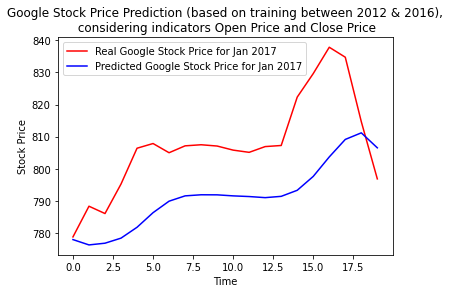

In [11]:
#visualize the results
plt.plot(real_stock_price[:, 0], color = 'red', label = 'Real Google Stock Price for Jan 2017')
plt.plot(predicted_stock_close_price_2D[:, 0], color = 'blue', label = 'Predicted Google Stock Price for Jan 2017')
plt.title('Google Stock Price Prediction (based on training between 2012 & 2016),\n considering indicators Open Price and Close Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [12]:
import math
from sklearn.metrics import mean_squared_error
#divide rmse by 840 (range of stock price of Jan 2017) --> so we get a relative stock price
rmse_04_16 = (math.sqrt(mean_squared_error(real_stock_price[:, 0], predicted_stock_close_price_2D[:, 0]))) / 840
rmse_04_16 

0.022594626874556205

In [13]:
#reshape arrays to vertical structure
real_stock_vert = np.reshape(real_stock_price[:, 0], (-1, 1))
pred_stock_vert = np.reshape(predicted_stock_close_price_2D[:, 0], (-1, 1))

#concat arrays horizontally
arrays_concat = np.concatenate((real_stock_vert, pred_stock_vert), axis = 1)

real_val_list = arrays_concat[:,0].tolist()
pred_val_list = arrays_concat[:,1].tolist()

#loop through columns of array and check directions
#if second value bigger than first value: give a 2
#if second value smaller than first value： give a 1

#get directions of real values
direction_list_realval = []
n = 0
for x in real_val_list:
    if real_val_list[n] > real_val_list[n-1]:
        direction_list_realval.append(2)
    else:
        direction_list_realval.append(1)
    n = n + 1  

#get directions of predicted values
direction_list_predval = []
n = 0
for x in pred_val_list:
    if pred_val_list[n] > pred_val_list[n-1]:
        direction_list_predval.append(2)
    else:
        direction_list_predval.append(1)
    n = n + 1

#change lists to arrays
real_val_array = np.array(real_val_list)
direction_array_realval = np.array(direction_list_realval)

pred_val_array = np.array(pred_val_list)
direction_array_predval = np.array(direction_list_predval)

#reshape to 2D array
real_val_2d = np.reshape(real_val_array, (-1, 1))
direction_2d_realval = np.reshape(direction_array_realval, (-1, 1))

pred_val_2d = np.reshape(pred_val_array, (-1, 1))
direction_2d_predval = np.reshape(direction_array_predval, (-1, 1))

val_dir = np.concatenate((real_val_2d, direction_2d_realval, pred_val_2d, direction_2d_predval), axis = 1)

#select direction columns from 2D array
list_ind = [1, 3]
val_bin = val_dir[:,list_ind]

correct_list = []
for x in val_bin:
  if x[0] == x[1]:
    correct_list.append(1)
  else:
    correct_list.append(0)

correct_list_array = np.reshape(correct_list, (-1, 1))

val_bin_correct = np.concatenate((val_bin, correct_list_array), axis = 1)

#calculate direction accuracy
dir_acc = sum(val_bin_correct[:,2]) / len(val_bin_correct)
dir_acc


0.7